# Tutorial 2: Primer to Ponder

In [1]:
import os; os.chdir("..")
import credential
import ponder.bigquery
import modin.pandas as pd
bigquery_con = ponder.bigquery.connect(user=credential.params["user"],password=credential.params["password"],account=credential.params["account"],role=credential.params["role"],database=credential.params["database"],schema=credential.params["schema"],warehouse=credential.params["warehouse"])
ponder.bigquery.init(bigquery_con)

## What is Ponder?

Ponder lets you run your pandas code directly in your data warehouse. This means that you can continue to write pandas, but with the scalability and security benefits of a modern data warehouse. 

### Key Features

- **Data science at all scales**: With Ponder's technology, the same pandas workflows can be run at all scales, from megabytes to terabytes, without changing a single line of code. 

- **No change to user workflow:** Data scientists can continue running their existing pandas workflows and writing pandas code in their favorite IDE of choice, and benefit from seamless scalability improvements.

- **Simplify your data infrastructure:** No need to set up and maintain compute infrastructure required for other parallel processing frameworks (e.g., Spark, Ray, Dask, etc.) to perform large scale data analysis with pandas.

- **Guaranteed security:** All your pandas workflows will be executed in BigQuery, thus benefiting from the rigorous security guarantees offered by BigQuery.

In the following sections, we will showcase some examples of how Ponder works and how it can be used in your work.

### Demo 1: Write SQL no more, Ponder in action!

Under the hood, pandas operations are automatically compiled down to SQL queries that get pushed to BigQuery. Queries are executed directly on BigQuery, with users benefiting from the performance, scalability, and security benefits provided by BigQuery as the computation engine.  

Here is an architecture of how Ponder works: 

<img src="https://ponder.io/wp-content/uploads/2023/01/Group-362.png" width="75%"></img>


To show you that this is actually running in the data warehouse, you can log onto your [BigQuery web interface](https://app.bigquery.com/). The pandas operations you execute on Ponder correspond to the SQL queries shown on the `Query History` page in BigQuery web interface.

In [2]:
df = pd.read_sql("PONDER_BOOKS", bigquery_con)

You can look at the corresponding SQL queries for the pandas operations ran in Ponder by going to `Activity` > `Query History` in your BigQuery web interface. The history page lets you view and drill into the details of queries executed in your BigQuery account in the last 14 days.

<img src="https://docs.ponder.io/_images/mon2.png" width="75%"></img>

In this case, you can see that as we connected to the table via `pd.read_sql`, this corresponding SQL query was generated: 

```sql
CREATE TEMP TABLE "Ponder_zmyffjgcyh" AS SELECT *, ROW_NUMBER() OVER (ORDER BY 1) -1 AS _PONDER_ROW_NUMBER_, _PONDER_ROW_NUMBER_ AS _PONDER_ROW_LABELS_ FROM ("PONDER_BOOKS")
```

You might recall that in the last tutorial, we performed z-score normalization on all the numerical columns. 

In [3]:
x = df.select_dtypes(include='number').columns
(df[x] - df[x].mean())/df[x].std()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
0,-1.627423,1.814764,0.046421,1.308412,18.465698,10.495965
1,-1.627347,1.586444,0.046420,2.212309,18.976518,11.128467
2,-1.627194,1.386663,0.046420,0.064518,-0.103230,-0.115700
3,-1.627118,1.786224,0.046420,0.408662,20.633287,13.885086
4,-1.626888,2.414107,0.046420,9.758604,0.208673,-0.146743
...,...,...,...,...,...,...
11114,1.857626,0.359219,0.048950,0.727928,-0.158127,-0.202621
11115,1.857779,0.416299,0.045744,1.237925,-0.152555,-0.188651
11116,1.857855,0.073818,0.045744,0.325735,-0.152226,-0.173518
11117,1.858237,-0.611144,0.045565,0.404515,-0.152679,-0.156444


Now take a look at BigQuery's `Query History`, the corresponding SQL query is 200+ lines long!!

```sql
SELECT 
  "_PONDER_ROW_LABELS_", 
  "bookID", 
  "average_rating", 
  "isbn13", 
  "  num_pages", 
  "ratings_count", 
  "text_reviews_count" 
FROM 
  (
    SELECT 
      * 
    FROM 
      (
        SELECT 
          "_PONDER_ROW_NUMBER_", 
          "_PONDER_ROW_LABELS_", 
          "bookID" / "bookID_ponder_right" AS "bookID", 
          "average_rating" / "average_rating_ponder_right" AS "average_rating", 
          "isbn13" / "isbn13_ponder_right" AS "isbn13", 
          "  num_pages" / "  num_pages_ponder_right" AS "  num_pages", 
          "ratings_count" / "ratings_count_ponder_right" AS "ratings_count", 
          "text_reviews_count" / "text_reviews_count_ponder_right" AS "text_reviews_count" 
        FROM 
          (
            SELECT 
              "_PONDER_ROW_NUMBER_", 
              "_PONDER_ROW_LABELS_", 
              "bookID" - "bookID_ponder_right" AS "bookID", 
              "average_rating" - "average_rating_ponder_right" AS "average_rating", 
              "isbn13" - "isbn13_ponder_right" AS "isbn13", 
              "  num_pages" - "  num_pages_ponder_right" AS "  num_pages", 
              "ratings_count" - "ratings_count_ponder_right" AS "ratings_count", 
              "text_reviews_count" - "text_reviews_count_ponder_right" AS "text_reviews_count" 
            FROM 
              (
                SELECT 
                  "_PONDER_ROW_NUMBER_", 
                  "_PONDER_ROW_LABELS_", 
                  "bookID", 
                  "average_rating", 
                  "isbn13", 
                  "  num_pages", 
                  "ratings_count", 
                  "text_reviews_count" 
                FROM 
                  (
                    SELECT 
                      "bookID", 
                      "title", 
                      "authors", 
                      "average_rating", 
                      "isbn", 
                      "isbn13", 
                      "language_code", 
                      "  num_pages", 
                      "ratings_count", 
                      "text_reviews_count", 
                      "publication_date", 
                      "publisher", 
                      "_PONDER_ROW_NUMBER_", 
                      "_PONDER_ROW_LABELS_" 
                    FROM 
                      "Ponder_zmyffjgcyh" 
                    ORDER BY 
                      "_PONDER_ROW_NUMBER_"
                  )
              ) AS _PONDER_LEFT_ CROSS 
              JOIN (
                SELECT 
                  "bookID" AS "bookID_ponder_right", 
                  "average_rating" AS "average_rating_ponder_right", 
                  "isbn13" AS "isbn13_ponder_right", 
                  "  num_pages" AS "  num_pages_ponder_right", 
                  "ratings_count" AS "ratings_count_ponder_right", 
                  "text_reviews_count" AS "text_reviews_count_ponder_right" 
                FROM 
                  (
                    SELECT 
                      0 AS _PONDER_ROW_NUMBER_, 
                      0 AS _PONDER_ROW_LABELS_, 
                      AVG("bookID") AS "bookID", 
                      AVG("average_rating") AS "average_rating", 
                      AVG("isbn13") AS "isbn13", 
                      AVG("  num_pages") AS "  num_pages", 
                      AVG("ratings_count") AS "ratings_count", 
                      AVG("text_reviews_count") AS "text_reviews_count" 
                    FROM 
                      (
                        SELECT 
                          "bookID" :: FLOAT AS "bookID", 
                          "average_rating" :: FLOAT AS "average_rating", 
                          "isbn13" :: FLOAT AS "isbn13", 
                          "  num_pages" :: FLOAT AS "  num_pages", 
                          "ratings_count" :: FLOAT AS "ratings_count", 
                          "text_reviews_count" :: FLOAT AS "text_reviews_count", 
                          "_PONDER_ROW_LABELS_", 
                          "_PONDER_ROW_NUMBER_" 
                        FROM 
                          (
                            SELECT 
                              "_PONDER_ROW_NUMBER_", 
                              "_PONDER_ROW_LABELS_", 
                              "bookID", 
                              "average_rating", 
                              "isbn13", 
                              "  num_pages", 
                              "ratings_count", 
                              "text_reviews_count" 
                            FROM 
                              (
                                SELECT 
                                  "bookID", 
                                  "title", 
                                  "authors", 
                                  "average_rating", 
                                  "isbn", 
                                  "isbn13", 
                                  "language_code", 
                                  "  num_pages", 
                                  "ratings_count", 
                                  "text_reviews_count", 
                                  "publication_date", 
                                  "publisher", 
                                  "_PONDER_ROW_NUMBER_", 
                                  "_PONDER_ROW_LABELS_" 
                                FROM 
                                  "Ponder_zmyffjgcyh" 
                                ORDER BY 
                                  "_PONDER_ROW_NUMBER_"
                              )
                          )
                      )
                  )
              ) AS _PONDER_RIGHT_
          ) AS _PONDER_LEFT_ CROSS 
          JOIN (
            SELECT 
              "bookID" AS "bookID_ponder_right", 
              "average_rating" AS "average_rating_ponder_right", 
              "isbn13" AS "isbn13_ponder_right", 
              "  num_pages" AS "  num_pages_ponder_right", 
              "ratings_count" AS "ratings_count_ponder_right", 
              "text_reviews_count" AS "text_reviews_count_ponder_right" 
            FROM 
              (
                SELECT 
                  0 AS _PONDER_ROW_NUMBER_, 
                  0 AS _PONDER_ROW_LABELS_, 
                  STDDEV("bookID") AS "bookID", 
                  STDDEV("average_rating") AS "average_rating", 
                  STDDEV("isbn13") AS "isbn13", 
                  STDDEV("  num_pages") AS "  num_pages", 
                  STDDEV("ratings_count") AS "ratings_count", 
                  STDDEV("text_reviews_count") AS "text_reviews_count" 
                FROM 
                  (
                    SELECT 
                      "_PONDER_ROW_NUMBER_", 
                      "_PONDER_ROW_LABELS_", 
                      "bookID", 
                      "average_rating", 
                      "isbn13", 
                      "  num_pages", 
                      "ratings_count", 
                      "text_reviews_count" 
                    FROM 
                      (
                        SELECT 
                          "bookID", 
                          "title", 
                          "authors", 
                          "average_rating", 
                          "isbn", 
                          "isbn13", 
                          "language_code", 
                          "  num_pages", 
                          "ratings_count", 
                          "text_reviews_count", 
                          "publication_date", 
                          "publisher", 
                          "_PONDER_ROW_NUMBER_", 
                          "_PONDER_ROW_LABELS_" 
                        FROM 
                          "Ponder_zmyffjgcyh" 
                        ORDER BY 
                          "_PONDER_ROW_NUMBER_"
                      )
                  )
              )
          ) AS _PONDER_RIGHT_
      ) 
    WHERE 
      "_PONDER_ROW_NUMBER_" IN (
        '0', '1', '2', '3', '4', '5', '6', '7', 
        '8', '9', '10', '11', '12', '13', '14', 
        '15', '16', '17', '18', '19', '20', 
        '21', '22', '23', '24', '25', '26', 
        '27', '28', '29', '30', '11088', '11089', 
        '11090', '11091', '11092', '11093', 
        '11094', '11095', '11096', '11097', 
        '11098', '11099', '11100', '11101', 
        '11102', '11103', '11104', '11105', 
        '11106', '11107', '11108', '11109', 
        '11110', '11111', '11112', '11113', 
        '11114', '11115', '11116', '11117', 
        '11118'
      )
  ) 
ORDER BY 
  _PONDER_ROW_NUMBER_ 
LIMIT 
  10001
```

In this example, we saw how something as easy to express in pandas in a single line can in fact take *many* lines of SQL to write. 

Using Ponder leads to huge time-savings since you can think and work natively in pandas when interacting with your data warehouse.

### Demo 2: Scaling Ponder on big data

Ponder is built on our open-source project, [Modin](https://modin.readthedocs.io/en/latest/), which is a faster, more scalable version of pandas. Modin has more than 5M+ downloads to-date and is being adopted in leading data and AI teams. We built Modin and Ponder to address the scalability bottlenecks that practitioners face when using pandas (which is single-threaded and often leads to out-of-memory errors). But unlike other big data frameworks (e.g., Spark, SQL), we let you continue using the same pandas API and semantics, while doing the magic behind the scenes to let you scale on hundreds of GB up to terabytes of data.

In [4]:
import time

In this demo, we perform a series of operations with Ponder and Pandas to compare the performance of working with large datasets. 

First, we load in the CSV file which contains the NYC taxi dataset. The size of this CSV file is 22.6MB.

In [5]:
df = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/yellow_tripdata_2015-01.csv?raw=True", on_bad_lines='skip')

Determining schema for file...
Finished determining schema for file...
Creating table in BigQuery...
Finished creating table in BigQuery...
Uploading file...
Finished uploading file...
Loading dataframe...
Dataframe loading complete.


In [6]:
start  = time.time()
bigdf = pd.concat([df for _ in range(100)])
end = time.time()
ponder_concat_duration = end - start

In [7]:
print("Time for concat with Ponder: {} seconds".format(round(ponder_concat_duration, 2)))

Time for concat with Ponder: 0.7 seconds


In [8]:
start  = time.time()
display(bigdf.groupby("PASSENGER_COUNT").mean())
end = time.time()
ponder_groupby_duration = end - start

,Index,Unnamed,VENDORID,TRIP_DISTANCE,RATECODEID,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,CONGESTION_SURCHARGE,AIRPORT_FEE,
PASSENGER_COUNT,,,,,,,,,,,,,,,,,,
0,98533.847826,98533.847826,1.130435,2.141739,9.043478,165.130435,154.217391,1.652174,17.150435,0.250000,0.304348,0.948043,0.423913,0.039130,19.357174,NaN,NaN,NaN
1,127245.301366,127245.301366,1.506007,3.289600,1.045137,155.058457,151.812726,1.510181,12.861238,0.269200,0.496114,1.329329,0.202550,0.150203,15.455671,NaN,NaN,NaN
2,122094.974194,122094.974194,1.466004,3.608892,1.066553,155.405790,152.076833,1.496764,13.963329,0.289076,0.494514,1.443935,0.319719,0.138124,16.807681,NaN,NaN,NaN
3,119083.814283,119083.814283,1.491227,3.568215,1.061660,153.808708,151.956543,1.538291,13.929069,0.304526,0.493727,1.324659,0.302686,0.146261,16.652097,NaN,NaN,NaN
4,122507.548275,122507.548275,1.393275,3.652979,1.101025,153.760427,151.656227,1.603839,14.444529,0.288786,0.492062,1.177842,0.378460,0.116380,17.078130,NaN,NaN,NaN
5,124279.908421,124279.908421,1.989759,3.456300,1.023275,153.885231,150.142192,1.497080,13.201483,0.288320,0.497757,1.330433,0.248330,0.292383,15.861550,NaN,NaN,NaN
6,132136.921299,132136.921299,1.998547,3.384467,1.021260,152.325763,150.321933,1.495180,12.905982,0.254259,0.498812,1.305881,0.212104,0.297148,15.474779,NaN,NaN,NaN


In [35]:
print("Time for groupby.mean with Ponder: {} seconds".format(round(ponder_groupby_duration, 2)))

Time for groupby.mean with Ponder: 19.15 seconds


In [10]:
import pandas as old_pd

In [11]:
pandas_df = old_pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/yellow_tripdata_2015-01.csv?raw=True", on_bad_lines='skip')

In [12]:
start  = time.time()
pandas_bigdf = old_pd.concat([pandas_df for _ in range(100)])
end = time.time()
pandas_concat_duration = end - start

In [13]:
print("Time for concat with pandas: {} seconds".format(round(pandas_concat_duration, 2)))

Time for concat with pandas: 26.45 seconds


In [14]:
start  = time.time()
display(pandas_bigdf.groupby("PASSENGER_COUNT").mean())
end = time.time()
pandas_groupby_duration = end - start

,Index,Unnamed,VENDORID,TRIP_DISTANCE,RATECODEID,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,CONGESTION_SURCHARGE,AIRPORT_FEE,
PASSENGER_COUNT,,,,,,,,,,,,,,,,,,
0,98533.847826,98533.847826,1.130435,2.141739,9.043478,165.130435,154.217391,1.652174,17.150435,0.250000,0.304348,0.948043,0.423913,0.039130,19.357174,NaN,NaN,NaN
1,127245.301366,127245.301366,1.506007,3.289600,1.045137,155.058457,151.812726,1.510181,12.861238,0.269200,0.496114,1.329329,0.202550,0.150203,15.455671,NaN,NaN,NaN
2,122094.974194,122094.974194,1.466004,3.608892,1.066553,155.405790,152.076833,1.496764,13.963329,0.289076,0.494514,1.443935,0.319719,0.138124,16.807681,NaN,NaN,NaN
3,119083.814283,119083.814283,1.491227,3.568215,1.061660,153.808708,151.956543,1.538291,13.929069,0.304526,0.493727,1.324659,0.302686,0.146261,16.652097,NaN,NaN,NaN
4,122507.548275,122507.548275,1.393275,3.652979,1.101025,153.760427,151.656227,1.603839,14.444529,0.288786,0.492062,1.177842,0.378460,0.116380,17.078130,NaN,NaN,NaN
5,124279.908421,124279.908421,1.989759,3.456300,1.023275,153.885231,150.142192,1.497080,13.201483,0.288320,0.497757,1.330433,0.248330,0.292383,15.861550,NaN,NaN,NaN
6,132136.921299,132136.921299,1.998547,3.384467,1.021260,152.325763,150.321933,1.495180,12.905982,0.254259,0.498812,1.305881,0.212104,0.297148,15.474779,NaN,NaN,NaN


In [15]:
print("Time for groupby.mean with pandas: {} seconds".format(round(pandas_groupby_duration, 2)))

Time for groupby.mean with pandas: 68.19 seconds


In [ ]:
# Install matplotlib if you don't already have it
! pip install matplotlib

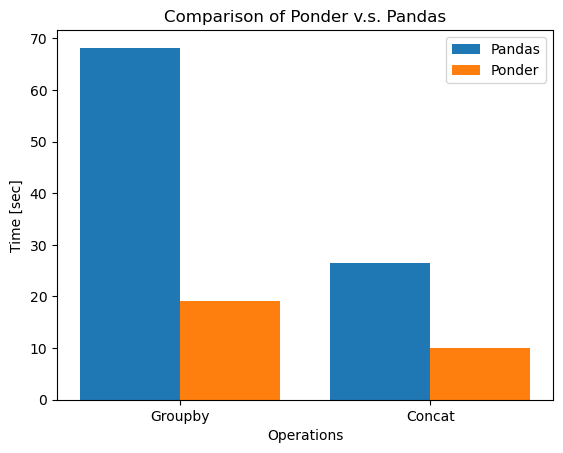

In [37]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Groupby','Concat']
t_pandas = [pandas_groupby_duration,pandas_concat_duration]
t_ponder = [ponder_groupby_duration,ponder_concat_duration]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, t_pandas, 0.4, label = 'Pandas')
plt.bar(X_axis + 0.2, t_ponder, 0.4, label = 'Ponder')
  
plt.xticks(X_axis, X)
plt.xlabel("Operations")
plt.ylabel("Time [sec]")
plt.title("Comparison of Ponder v.s. Pandas")
plt.legend()
plt.show()

### Summary

In this tutorial, we saw how Ponder lets you run pandas on BigQuery. 

Demo #1 showed how Ponder simplifies your experience in working with data. It does this by translating your pandas queries to corresponding SQL queries to run on your data warehouse. Ponder gives you the flexibility of working in pandas directly and often there are queries that are easier to write in pandas than having to craft hundreds of lines of SQL!

Demo #2 showed the scale benefits you get from using Ponder in working with large datasets. We saw that Ponder leverages the inherent parallelism of the data warehouse to speed up your pandas queries, leading to runtimes that are much faster than vanilla pandas.

As we can see, there are many benefits from being able to leverage the pandas API (over writing SQL directly) on your data warehouse, as summarized in this table. 

|               | pandas | SQL | Ponder |
|---------------|--------|-----|--------|
| Easy to use   | ✅      | ❌   | ✅      |
| Flexible      | ✅      | ❌   | ✅      |
| Scalable      | ❌      | ✅   | ✅      |
| Secure access | ❌      | ✅   | ✅      |


To learn more about Ponder, check out our product blogpost [here](https://ponder.io/run-pandas-on-1tb-directly-in-your-data-warehouse/).